----------------------

<div style=" font-size: 30px">
    
__Проект: Статистический анализ данных__
</div>


<div style=" font-size: 20px">
    

    
    Побудем в роли аналитика популярного сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
</div>

Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.


__Пользователи — users_go.csv__
- user_id, уникальный идентификатор пользователя
- name,	имя пользователя
- age, возраст
- city,	город
- subscription_type, тип подписки (free, ultra)

__Поездки — rides_go.csv__
- user_id, уникальный идентификатор пользователя
- distance,	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration,	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date, дата совершения поездки

__Подписки — subscriptions_go.csv__
- subscription_type, тип подписки
- minute_price,	стоимость одной минуты поездки по данной подписке
- start_ride_price,	стоимость начала поездки
- subscription_fee,	стоимость ежемесячного платежа.

Изучим данные и опеределим ключевые характеристики для бизнеса: выручку, более выгодных клиентов, проверим гипотезы на предмет предстоящих акций.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from math import factorial
from scipy.stats import binom

#### Шаг 1. Загрузка данных

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
data_riders = pd.read_csv('/datasets/rides_go.csv')
data_riders.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
data_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
data_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
data_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Были изучены данные трех файлов. Пропусков не было найдено, змеиный стиль соблюдается везде. Данные готовы к работе, но тем не менее, требуется проверка на наличие дубликатов и корректный тип данных.

#### Шаг 2. Предобработка данных

In [8]:
data_users.duplicated().sum() # проверяем датафрейм data_users на наличие дубликатов

31

In [9]:
pd.DataFrame(round(data_riders.isna().mean()*100,)).style.background_gradient('coolwarm') # проверяем датафрейм data_riders на наличие дубликатов

,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000


In [10]:
data_subscriptions.duplicated().sum() # проверяем датафрейм data_subscriptions на наличие дубликатов

0

In [11]:
data_users = data_users.drop_duplicates() # убираем дубликаты

In [12]:
data_users.duplicated().sum() # делаем повторную проверку на дубликаты после удаления

0

In [13]:
pd.DataFrame(round(data_users.isna().mean()*100,)).style.background_gradient('coolwarm') # поиск пропущенных значений

,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000


In [14]:
pd.DataFrame(round(data_riders.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000


In [15]:
pd.DataFrame(round(data_subscriptions.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
subscription_type,0.000000
minute_price,0.000000
start_ride_price,0.000000
subscription_fee,0.000000


In [16]:
data_riders['distance'].round(1) # окпугляем до десятых

0        4409.9
1        2617.6
2         754.2
3        2694.8
4        4028.7
          ...  
18063    3781.1
18064    2840.4
18065    3826.2
18066    2902.3
18067    2371.7
Name: distance, Length: 18068, dtype: float64

In [17]:
data_riders['date'] = pd.to_datetime(data_riders['date'], format='%Y-%m-%d') # перевод в временной формат

In [18]:
data_riders['month'] = data_riders['date'].dt.month # создание столбца с номером месяца

In [19]:
data_riders['date'].unique() # как видим в стобце данные только за 2021 год.

array(['2021-01-01T00:00:00.000000000', '2021-01-18T00:00:00.000000000',
       '2021-04-20T00:00:00.000000000', '2021-08-11T00:00:00.000000000',
       '2021-08-28T00:00:00.000000000', '2021-10-09T00:00:00.000000000',
       '2021-10-19T00:00:00.000000000', '2021-11-06T00:00:00.000000000',
       '2021-11-14T00:00:00.000000000', '2021-11-22T00:00:00.000000000',
       '2021-12-14T00:00:00.000000000', '2021-12-22T00:00:00.000000000',
       '2021-03-15T00:00:00.000000000', '2021-03-18T00:00:00.000000000',
       '2021-03-23T00:00:00.000000000', '2021-04-08T00:00:00.000000000',
       '2021-04-13T00:00:00.000000000', '2021-06-20T00:00:00.000000000',
       '2021-07-02T00:00:00.000000000', '2021-07-18T00:00:00.000000000',
       '2021-08-03T00:00:00.000000000', '2021-10-27T00:00:00.000000000',
       '2021-12-18T00:00:00.000000000', '2021-01-31T00:00:00.000000000',
       '2021-02-24T00:00:00.000000000', '2021-02-26T00:00:00.000000000',
       '2021-04-12T00:00:00.000000000', '2021-05-07

Была проведена предобработка данных:
- в файле data_users были удалены явные дубликаты
- пропусков найдено не было
- в таблице data_riders значения стоблцов с длительностью и дистанцией поездки были окгруглены до десятых. Столбец date был приведен к типу данных datetime. Наконец был добавлен столбец с номером месяца.

Данные полностью готовы к анализу.

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:

1. Частота встречаемости городов.

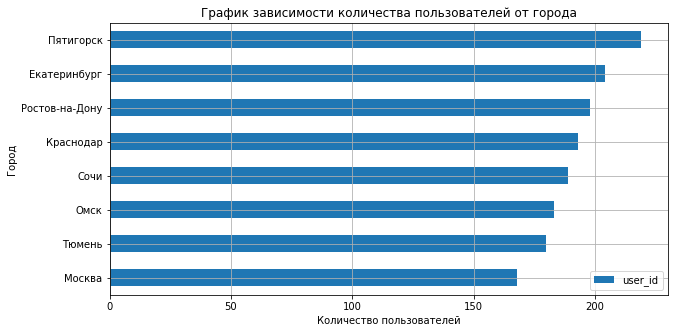

In [20]:
(
data_users.
    pivot_table(index='city', values='user_id', aggfunc='count').
    sort_values(by='user_id', ascending=True).
    plot(kind='barh', grid=True, figsize=(10, 5), title='График зависимости количества пользователей от города')
)
plt.ylabel('Город')
plt.xlabel('Количество пользователей')
plt.show()

In [21]:
(
data_users.
    pivot_table(index='city', values='user_id', aggfunc='count').
    sort_values(by='user_id', ascending=False)
)

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


Неожиданно, но в Пятигорске больше всех любят кататься на самокатах. Москва как самый населенный город нашей страны располагается на последней строчке. С первого взгляда можно проследить только одну закономерность:
- первую половину рейтинга занимают города с юга, за исключением Екатеринбурга.

Нужно проверить по дате аренды, можно предположить что это теплое время года.

2. Соотношение пользователей с подпиской и без подписки.

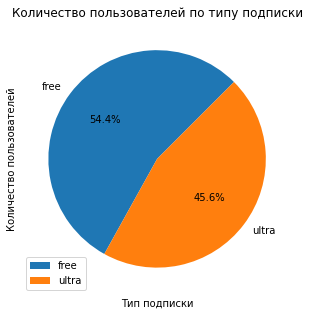

In [22]:
(
data_users.
    pivot_table(index='subscription_type', values='user_id', aggfunc='count').
    plot.pie(y='user_id', figsize=(5, 5), title='Количество пользователей по типу подписки', autopct='%1.1f%%', startangle=45)
)
plt.ylabel('Количество пользователей')
plt.xlabel('Тип подписки')
plt.show()

In [23]:
data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')

,user_id
subscription_type,
free,835
ultra,699


Количество пользователей с подпиской и без не сильно различается:
- 699 против 835 соответсвенно, практически поровну.

3. Возраст пользователей

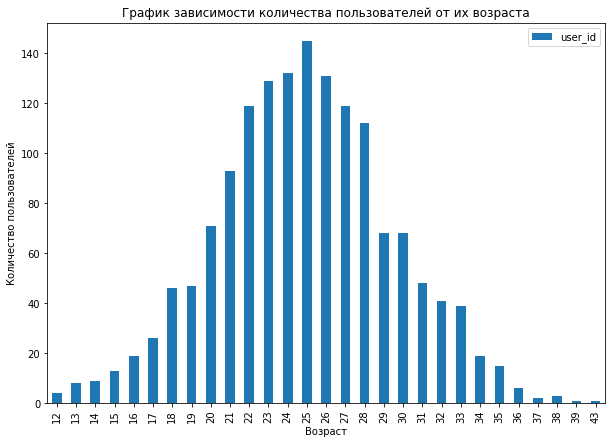

In [24]:
(
data_users.
    pivot_table(index='age', values='user_id', aggfunc='count').
    plot(kind='bar', figsize=(10, 7), title='График зависимости количества пользователей от их возраста')
)
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
plt.show()

In [25]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

График зависимости количества пользователей от их возраста похож на нормальное распределение. Средний возраст 24.9, медианный - 25.

4. Расстояние, которое пользователь преодолел за одну поездку.

In [26]:
data_riders['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

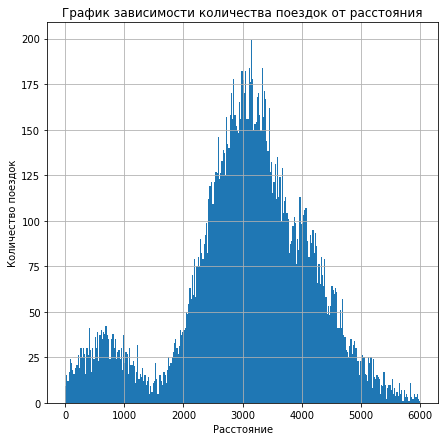

In [27]:
data_riders['distance'].hist(
    bins=300,
    range=(1, 6000), 
    figsize=(7, 7),
    )
plt.title('График зависимости количества поездок от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Наблюдается два пика: на 700м и на 3200м, в целом график похож на нормальное распределение, хотя некоторые резкие подъемы нельзя оставлять без внимания.

5. Продолжительность поездок.

In [28]:
data_riders['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

<AxesSubplot:>

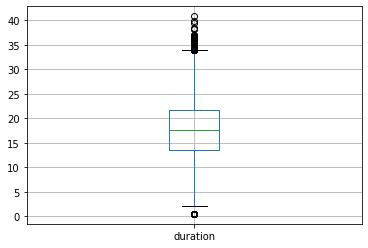

In [29]:
data_riders.boxplot(['duration'])

Видим аномальные значения ниже 3 и выше 34.

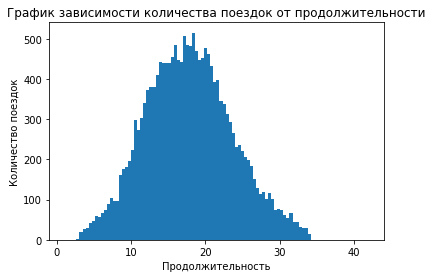

In [30]:

plt.hist(data_riders.query('(duration > 3) & (duration < 34)')['duration'],
         bins=100,
         range=(1, 42)
        )
plt.title('График зависимости количества поездок от продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.show()

Видим нормальное распределение, пик на 18 минутах.


Итоги исследовательского анализа:
- Больше всего прокатом самокатов пользуются в южный городах и в Екатеринбурге.
- Людей без подписски больше чем с ней, хотя и не намного.
- Средний и медианный возраст арендатора самоката 25 лет
- чаще всего преодолевают расстояние либо в 700м либо в 3200м, для более точного ответа лучше обратиться к графику.
- 18 минут- такая самая частая продолжительность поездки при нормальном распределении, как в нашем случае.

#### Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм. 

In [31]:
data_u_r = data_users.merge(data_riders, on='user_id', how='left')

In [32]:
data_urs = data_u_r.merge(data_subscriptions, on='subscription_type', how='left')
data_urs.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [33]:

if len(data_riders) == len(data_urs):
    print('лишних или недостающих строк нет')
else:
    print('перепроверить')

лишних или недостающих строк нет


In [34]:
data_urs.duplicated().sum() # проверка на дубликаты

0

In [35]:
data_urs.isna().sum() # поиск пропущенных значений

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Создадим ещё два датафрейма из датафрейма data_urs

Датафрейм с подпиской

In [36]:
data_ultra = data_urs.query('subscription_type == "ultra"')

Датафрейм без подписки

In [37]:
data_free = data_urs.query('subscription_type == "free"')

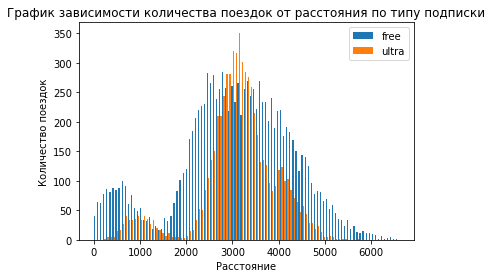

In [38]:
plt.hist([data_free['distance'], data_ultra['distance']], bins=100, range=(1,6600), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('График зависимости количества поездок от расстояния по типу подписки')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

По графику видно что у ultra меньше разброс, чем у free. Пик наблюдается примерно в одном месте. У людей с подпиской больше поездок приближенных к медианному значению.


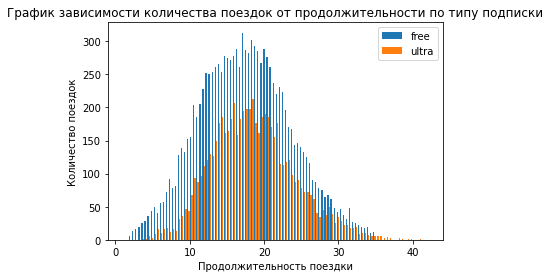

In [39]:
plt.hist([data_free['duration'], data_ultra['duration']], bins=100, range=(1,42), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('График зависимости количества поездок от продолжительности по типу подписки')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Можно увидеть у тех у кого нет подписки количество поездок больше вне зависимоти от продолжительнсти.

На этом этапе мы объединили три таблицы data_users, data_riders и data_subscriptions в один датафрейм data_urs.
Также на основе data_urs было создано еще два датафрейма:
- с подпиской data_ultra
- без подписки data_free
Также были постоены графики зависимости количества поездок от расстояния и продолжительности и они показали,что:
- люди без подписки проезжают большее расстояния но значения дальше от медианного.
- у тех кто пользуется подпиской количество поездок вне зависимости от продолжительности меньше.

#### Шаг 5. Подсчёт выручки

1. Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [40]:
user_month = data_urs.pivot_table(
    index=('user_id', 'month'), 
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee',
        'subscription_type'

    ),
    aggfunc=({'distance':{'count', 'sum'}, 
             'duration':'sum',
             'minute_price': 'mean',
             'start_ride_price':'mean',
             'subscription_fee':'mean'})
)

user_month.columns = [
    'count', 'total_distance', 
    'total_duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee',
]
user_month.head()

count  total_distance  total_duration  minute_price  \
user_id month                                                        
1       1          2     7027.511294       41.416640             6   
        4          1      754.159807        6.232113             6   
        8          2     6723.470560       44.776802             6   
        10         2     5809.911100       31.578017             6   
        11         3     7003.499363       53.397424             6   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                     0               199  
        4                     0               199  
        8                     0               199  
        10                    0               199  
        11                    0               199

2. В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [41]:
user_month['income'] = (
user_month['start_ride_price']*user_month['count']+
user_month['minute_price']*user_month['total_duration']+
user_month['subscription_fee'])

In [42]:
user_month.head()

count  total_distance  total_duration  minute_price  \
user_id month                                                        
1       1          2     7027.511294       41.416640             6   
        4          1      754.159807        6.232113             6   
        8          2     6723.470560       44.776802             6   
        10         2     5809.911100       31.578017             6   
        11         3     7003.499363       53.397424             6   

               start_ride_price  subscription_fee      income  
user_id month                                                  
1       1                     0               199  447.499843  
        4                     0               199  236.392681  
        8                     0               199  467.660815  
        10                    0               199  388.468102  
        11                    0               199  519.384541

In [43]:
print ('Итоговвая выручка составила :', user_month['income'].sum(), 'руб.')

Итоговвая выручка составила : 3813028.731484988 руб.


Здесь мы создали сводную таблицу и посчитали выручку помесячно для каждого клиента, это позволило нам быстро посчитать суммарную выручку - 3 878 641 р.

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.


6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Гипотезы:
- Hо - средняя продолжительность поездки с подпиской и без равна.
- H1 - средняя продолжительность поездки с подпиской больше среднего подписки free.

In [44]:
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


По результатам теста отвергаем нулевую гипотезую. Есть основания полагать что средняя продолжительность поездки с подпиской больше средней продолжительности без подписки.

6.2 Расстояние одной поездки в 
3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Гипотезы:
- Ho: Среднее расстояние поездок с подпиской ultra равно не превышает 3130 метров.
- Н1: Среднее расстояние поездок с подпиской ultra больше оптимального в 3130 метров.

In [45]:
distance = 3130
alpha = 0.05
results = st.ttest_1samp(data_ultra['distance'], distance, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Можно сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

6.3 Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Гипотезы:
- Ho - помесячная выручка ultra равно помесячной выручке free.
- H1 - помесячная выручка ultra больше чем помесячная выручка free.


In [46]:
results = st.ttest_ind(user_month.loc[user_month['subscription_fee'] == 199, 'income'],
                       user_month.loc[user_month['subscription_fee'] == 0, 'income'],
                       alternative = 'greater')
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.899911210580282e-37
Отвергаем нулевую гипотезу


По результатам теста отвергаем нулевую гипотезу, имеем право полагать что выручка с ultra выше чем с free.

6.4 Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: так как мы измеряем одну и ту же генеральную выборку, то нам подойдет метод scipy.stats.ttest_rel().

Вывод по разделу:
- Есть основания полагать, что у людей с подпиской продолжительность средняя продолжительность поезди выше, чем у людей без нее.
- Тест показал, что люди в среднем не превышают оптимальное заданный лимит пробега самоката в 3130 метров.
- Люди с подпиской являются более выгодными клиентами для сервиса.
- Для проверки последней гипотезы, можно воспользоваться методом scipy.stats.ttest_rel() для двух зависимых выборок.

Итоговый вывод:

1.
- Были изучены данные трех файлов. Пропусков не было найдено, змеиный стиль соблюдается везде. В целом качество данных удовлетворительно, но для качественного анализа потребовалась предобработка данных.

2.
Была проведена предобработка данных:
- в файле data_users были удалены явные дубликаты, пропусков найдено не было
- в таблице data_riders значения стоблцов с длительностью и дистанцией поездки были окгруглены до десятых. Столбец date был приведен к типу данных datetime64. Наконец был добавлен столбец с номером месяца 'month'.

3.
По итогам исследовательского анализа было выявлено следующее:
- Больше всего прокатом самокатов пользуются в южный городах и в Екатеринбурге.
- Людей без подписски больше чем с ней, хотя и не намного.
- Средний и медианный возраст арендатора самоката 25 лет
- чаще всего преодолевают расстояние либо в 700м либо в 3200м, для более точного ответа лучше обратиться к графику.
- 18 минут- такая самая частая продолжительность поездки при нормальном распределении, как в нашем случае.

4.
Объединили данные data_users, data_riders и data_subscriptions в один датафрейм data_urs.
Также на основе data_urs было создано еще два датафрейма:
- с подпиской data_ultra
- без подписки data_free
Также были постоены графики зависимости количества поездок от расстояния и продолжительности и они показали,что:
- люди без подписки проезжают большее расстояния но значения дальше от медианного.
- у тех кто пользуется подпиской количество поездок вне зависимости от продолжительности меньше.

5.
Выручка компании составила 3 878 641 рублей.

6.
Были проверены несколько гипотез и сделаны следующие выводы:
- Есть основания полагать, что у людей с подпиской продолжительность средняя продолжительность поезди выше, чем у людей без нее.
- Тест показал, что люди в среднем не превышают оптимальное заданный лимит пробега самоката в 3130 метров.
- Люди с подпиской являются более выгодными клиентами для сервиса.
- Для проверки последней гипотезы, можно воспользоваться методом scipy.stats.ttest_rel() для двух зависимых выборок.

7. нужна помощь)

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10%
пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.

In [47]:
n = 1000
p = 0.1
k = 99
binom_cdf = 0.05

while binom_cdf < binom.cdf(k, n, p):
    n += 1
print(f'{n} - минимальное число промокодов, чтобы  вероятность не выполнить план была меньше 5%')

1161 - минимальное число промокодов, чтобы  вероятность не выполнить план была меньше 5%


7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

вероятность что уведомление откроют не более 399,5 тыс. пользователей: 0.15371708296369768


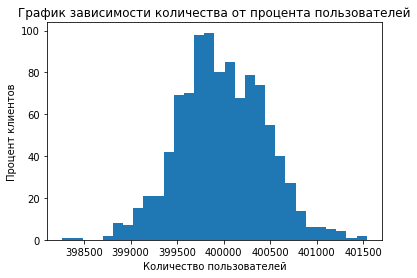

In [48]:
n = 1000000
p = 0.4
mu = n * p
sigma = (n * p * (1 - p))**0.5
distr=st.norm(mu, sigma)
result = distr.cdf(399500)
print('вероятность что уведомление откроют не более 399,5 тыс. пользователей:', result)
s = np.random.normal(mu, sigma, 1000) # генерируем значения для нормального распределения


plt.hist(s, 30) # строим гистограмму
plt.title('График зависимости количества от процента пользователей')
plt.ylabel('Процент клиентов')
plt.xlabel('Количество пользователей')

plt.show()

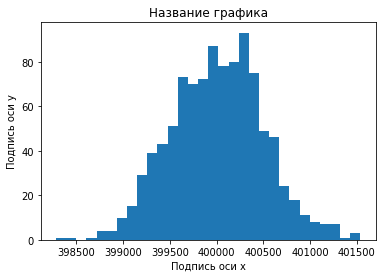

In [49]:
# Код ревьюера

s = np.random.normal(mu, sigma, 1000) # генерируем значения для нормального распределения


plt.hist(s, 30) # строим гистограмму
plt.title('Название графика')
plt.ylabel('Подпись оси y')
plt.xlabel('Подпись оси х')

plt.show()